In [623]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [624]:
df = pd.read_csv("../../pre_processing/datasets/no_filtered_analysis.csv", sep = ",")

In [611]:
if "RA" in df.columns:
    print("Removing column RA")
    df.drop('RA', inplace=True, axis=1)

Removing column RA


In [612]:
df.head()

,EVADIDO,RESID_ARARAS,BOLSISTA,GRADE_CORRENTE,NOTA_MEDIA,PONTUACAO_PS,TOT_MAT_CURSADAS,TOT_APROVACOES,TOT_REPROVACOES,TOT_REPROV_FREQ,...,SIF029,SIF030,SIF038,SIF039,SIF070,NCS037,NCS040,SIF006,SIF072,SIF073
0,0,1,1,2019,7.0,47.0,10,9,1,0,...,4,0,0,0,0,0,0,0,1,1
1,1,0,1,2016,5.5,47.0,18,15,3,3,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,2014,3.0,46.0,12,6,6,0,...,0,0,0,0,0,0,0,4,0,0
3,1,0,1,2014,5.1,47.0,49,37,12,10,...,1,1,5,4,1,1,1,1,0,0
4,0,0,1,2019,5.4,30.0,10,8,2,2,...,0,0,0,0,0,0,0,0,2,1


In [613]:
X = df.iloc[:, df.columns != "EVADIDO"].values
y = df["EVADIDO"]

In [576]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [590]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [553]:
def find_best_k(n_tests):
    errors = []
    all_key_errors = []
    for i in range(0, n_tests):
        clf = KNeighborsClassifier(weights="distance",
                                   n_neighbors=1+i, p = 1,
                                   n_jobs = 10)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        error = np.mean(predictions != y_test)
        
        all_key_errors.append([i, error])
        
        errors.append(error)
        
    plt.figure(figsize=(12, 6))
    plt.plot(range(0, 40), errors, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')
    plt.xlabel('K Value')
    plt.ylabel('Mean Error')
    return(all_key_errors)

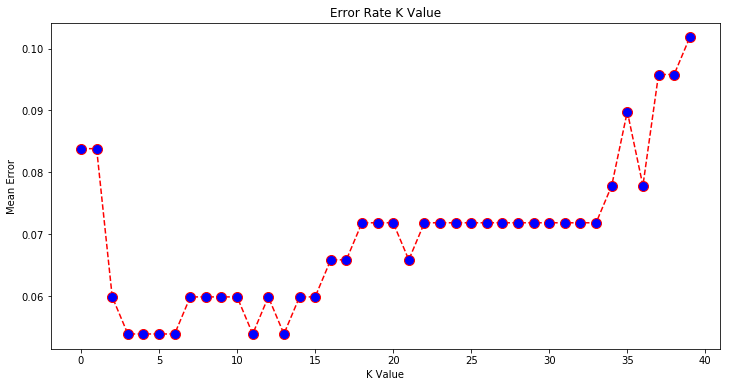

In [554]:
# Get best K
all_key_errors = find_best_k(40)

In [556]:
# return best k element
best_k = min(all_key_errors, key=lambda x: x[1])[0]
best_k

3

In [557]:
clf = KNeighborsClassifier(weights="distance", n_neighbors=best_k, p = 1, n_jobs = 10)

In [558]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=10, n_neighbors=3, p=1,
           weights='distance')

In [559]:
predictions = clf.predict(X_test)

In [560]:
predictions

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [561]:
np.asarray(y_test)

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int64)

In [562]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [563]:
print(confusion_matrix(y_test, predictions))

[[97  4]
 [ 6 60]]


In [564]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       101
           1       0.94      0.91      0.92        66

   micro avg       0.94      0.94      0.94       167
   macro avg       0.94      0.93      0.94       167
weighted avg       0.94      0.94      0.94       167



In [566]:
print("Model accuracy: ", accuracy_score(y_test, predictions), "%")

Model accuracy:  0.9401197604790419 %


In [595]:
# Predicions
for i in X_test:
    print(clf.predict_proba([i]))

[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0.33725513 0.66274487]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0.14953921 0.85046079]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0.65883619 0.34116381]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0.12131512 0.87868488]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[0.23037281 0.76962719]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0.66576359 0.33423641]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[0.38227943 0.61772057]]
[[0.65765733 0.34234267]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0.66666667 0.33333333]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0